# **Jigsaw Unintended Bias: Final Notebook**

# **Contents**
### 1. Define helper functions for text preprocessing and loading model
### 2. Build Preprocessing Pipeline using helper functions
### 3. Define a function to perform Tokenization and Padding
### 4. Define a Final Pipeline which inputs raw text and predicts toxicity
### 5. Define a function to visualize attention weights


In [1]:
!pip install demoji
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 KB 1.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.1/110.1 KB 14.4 MB/s eta 0:00:00


In [2]:
#import dependencies
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import re 
import pickle
import demoji
import contractions
import warnings
import time

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix

import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers, initializers, constraints
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Dense, Add, Concatenate
from tensorflow.keras.layers import  SpatialDropout1D, Dropout, GlobalMaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

from tensorflow.keras.models import Model

import random
import datetime
import gc
import pickle
import sys
import os
import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
train_pre = pd.read_pickle('/content/gdrive/MyDrive/Jigsaw Files/preprocessed_train.pkl')
train_pre.head()

,target,comment_text,preprcsd
0,0,"This is so cool. It's like, 'would you want yo...",cool like would want mother read really great ...
1,0,Thank you!! This would make my life a lot less...,thank would make life lot less anxiety induce ...
2,0,This is such an urgent design problem; kudos t...,urgent design problem kudos take impressive
3,0,Is this something I'll be able to install on m...,something able install site release
4,1,haha you guys are a bunch of losers.,haha guy bunch loser


In [ ]:
sample = train_pre.sample(n=5, random_state=120, ignore_index=False)
sample

,target,comment_text,preprcsd
273909,0,That is encouraging. Intelligent young folks g...,encourage intelligent young folk give us hope
1667385,0,So an illegal alien woman without American chi...,illegal alien woman without american child dep...
1123083,0,I agree with you. \nBut I think legalizing do...,agree think legalize send message use substanc...
178098,1,Well I bet it shut up a bunch of cry baby jeal...,well bet shut bunch cry baby jealous hater sur...
1208395,0,"Ahhh, another voice from the tolerant liberals...",ahhh another voice tolerant liberal keep insul...


# **1. Define helper functions for text preprocessing and loading model**

In [5]:
def lowercase(text):
    text = text.lower()
    return text

def expand_terms(text):
    text = contractions.fix(text)
    return text 

def strip_spaces(text):
    text = re.sub('\s{2,}', ' ', text)
    text = text.strip()
    return text

def handle_html_tags(text):
   #refer- https://stackoverflow.com/questions/2503413/regular-expression-to-stop-at-first-match
    text = re.sub('<.*?>', ' ', text)
    return text 

def handle_url(text):
    text = re.sub(r'(https?://[^\s]+|www\.[^\s]+)', ' ', text)
    return text

mispelled_dict = pickle.load(open("/content/gdrive/MyDrive/Jigsaw Files/mispelled.pkl", "rb"))

def replace_mispelled_words(text):
    words = word_tokenize(text)
    for word in words:
        if mispelled_dict.get(word, -1)!=-1:
            text = text.replace(word, mispelled_dict[word])
    return text

selected_emo = pickle.load(open("/content/gdrive/MyDrive/Jigsaw Files/selected_emo.pkl", "rb"))

def handle_special_char(text):
    text = re.sub(f'[^A-Za-z0-9{selected_emo} ]', ' ', text)
    return text

def handle_emoji_haul(text):
    ''' 
    1. Find all substrings where a single emoji occurs consquently, e.g. '🤣🤣🤣🤣' and '🤤😭🤤😭' occuring in string 'Haha! 🤣🤣🤣🤣 🤤😭🤤😭'
    2. '🤣🤣🤣🤣' -> '🤣'; '🤤😭🤤😭' -> '🤤😭'; We need to keep one and remove rest because users tend to overhaul on emoji usage which is not deemed important as per our problem
    '''
    
    # refer - https://stackoverflow.com/questions/51794651/remove-multiple-consecutive-occurrences-of-in-a-string-with-a-single-pytho
    emoji_haul = re.findall(f'(?:[{selected_emo}])+', text)

    for emo in emoji_haul:
        unique_emo = set(emo)
        if len(emo)==1 and len(unique_emo)==1:
            pass
        elif len(emo)>1 and len(unique_emo)==1:
            text = re.sub(emo, " "+emo[0]+" ", text)
        else:
            text = re.sub(emo, " "+" ".join(unique_emo)+" ", text)

    return text 

def emo2word(text):
    # preprocess
    text = handle_special_char(text) 
    text = handle_emoji_haul(text)
   
    # convert emoji to words; refer - https://www.geeksforgeeks.org/convert-emoji-into-text-in-python/
    text = demoji.replace_with_desc(text, ' ') 
    return text

# any term that contains a number, e.g: 129, 47as3a, io32, 98.:
def handle_numeric_terms(text): 
    text = re.sub('\S*[\d]\S*', ' ', text)
    return text

stop = pickle.load(open('/content/gdrive/MyDrive/Jigsaw Files/stop.pkl', 'rb'))
# refer - https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
def remove_stopwords(text):
    edited = " ".join([w for w in text.split(' ') if w not in stop]) 
    return edited

# code snippet - https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/#:~:text=Wordnet%20Lemmatizer%20(with%20POS%20tag)&text=This%20is%20because%20these%20words,%2C%20noun%2C%20adjective%20etc).
# WORDNET LEMMATIZER (with appropriate pos tags) 
lemmatizer = WordNetLemmatizer()

def pos_tagger(nltk_tag):
    ''' param pos: The Part Of Speech tag. Valid options are `"n"` for nouns,`"v"` for verbs, `"a"` for adjectives, `"r"` for adverbs and `"s"` for satellite adjectives.
        (from wordnet lemmatizer docs- https://www.nltk.org/_modules/nltk/stem/wordnet.html)
    '''
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

# Define function to lemmatize each word with its POS tag
def lemmatizer_withPOS(text):
    # tokenize the text and find the POS tag for each token
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text)) 
    
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
  
    lemmatized_text = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_text.append(word)
        else:       
            # else use the tag to lemmatize the token
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    lemmatized_text = " ".join(lemmatized_text)
    
    return lemmatized_text

In [6]:
def load_model(path, contain_custom_obj=False):
    config = pickle.load(open(path+'.pkl','rb'))
    if contain_custom_obj:
        custom_objects = {"AttentionWithContext": AttentionWithContext}
        with tf.keras.utils.custom_object_scope(custom_objects):
            model = tf.keras.Model.from_config(config['config'])
    else: 
        model = tf.keras.Model().from_config(config['config'])
    model.load_weights(path+'_weights.h5')
    return model

In [7]:
#code reference - https://mlwhiz.com/blog/2019/03/09/deeplearning_architectures_text_classification/ 
class AttentionWithContext(Layer):
    """
    Basically, hidden state of each timestep is passed through a hidden dense layer of n units, with a softmax layer on top which returns the attention weights for each timestep.
    The context vector is then calculated as the attention weighted sum of timestep hidden states.
    Input shape
        3D tensor with shape: (samples, steps, features).
    Output shape
        2D tensor with shape: (samples, features).
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, units=None,return_weights=False,**kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_weights = return_weights
        self.units = units
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        
        if self.units!=None:
            num_units = self.units
        else:
            num_units = input_shape[-1]
            
        self.W = self.add_weight(name = 'att_W',
                             shape =  (input_shape[-1], num_units),
                             initializer=self.init,
                             regularizer=self.W_regularizer,
                             constraint=self.W_constraint,
                             trainable=True)
        if self.bias:
            self.b = self.add_weight(name = 'att_b',
                                 shape = (num_units,),
                                 initializer='zero',
                                 regularizer=self.b_regularizer,
                                 constraint=self.b_constraint,
                                 trainable=True)
        self.u = self.add_weight(name = 'att_u',
                                 shape = (num_units,1),
                                 initializer=self.init,
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint,
                                 trainable=True)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = tf.matmul(x, self.W) #x(256,).W(256,128) -> uit(128,)

        if self.bias:
            uit += self.b #uit(128,)+b(128,) -> uit(128,)

        uit = tf.keras.activations.tanh(uit) #uit(128,)
        ait = tf.matmul(uit, self.u) #uit(128,).u(128,) -> ait(1,)

        a = tf.keras.activations.exponential(ait) #a(105,1) for all timesteps

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= tf.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        a /= tf.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx()) 

        weighted_input = x * a #x(105,256)*a(105,1)
        weighted_sum = K.sum(weighted_input,axis=1) #weighted_sum(256,) : context vector
        if self.return_weights:
            return [weighted_sum, a]
        return weighted_sum

    def compute_output_shape(self, input_shape):
        if self.units!=None:
            return input_shape[0], self.units
        return input_shape[0], input_shape[-1]
    
    def get_config(self):
        config = super(AttentionWithContext, self).get_config().copy()
        config.update({
            'W_regularizer': self.W_regularizer,
            'u_regularizer': self.u_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'u_constraint': self.u_constraint,
            'b_constraint': self.b_constraint,
            'bias' : self.bias,
            'units': self.units,
            'return_weights' : self.return_weights
        })
        return config

# **2. Build Preprocessing Pipeline using helper functions**

In [113]:
def PreprocessPipe(text):
    assert type(text)==str
    preprcsd =  lowercase(text)
    preprcsd =  expand_terms(preprcsd)
    preprcsd =  handle_html_tags(preprcsd)
    preprcsd =  handle_url(preprcsd)
    preprcsd =  replace_mispelled_words(preprcsd)
    preprcsd =  emo2word(preprcsd)
    preprcsd =  handle_numeric_terms(preprcsd)
    preprcsd =  strip_spaces(preprcsd)
    preprcsd =  remove_stopwords(preprcsd)
    preprcsd =  lemmatizer_withPOS(preprcsd)
    return np.array([preprcsd])

In [115]:
for text in sample['comment_text'].values:
    preprcsd_text = PreprocessPipe(text)
    print(preprcsd_text)

['encourage intelligent young folk give us hope']
['illegal alien woman without american child deport woman get preferential treatment not deport lucky enough fertile seriously crimes shall ignore perpetrator manage give birth let people evade consequence illegal behavior parent goodness know could lighten load prison court hurry people submit evidence reproduce']
['agree think legalize send message use substance option think would better help individual learn cop mechanism life not need option begin']
['well bet shut bunch cry baby jealous hater sure leave dumb found chase rainbow']
['ahhh another voice tolerant liberal keep insult half country get trump']


# **3. Define a function to perform Tokenization and Padding**

In [116]:
def tokenize_text(text, tokenizer, padlen):
    sequence = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequence, maxlen = padlen)
    return padded

In [117]:
tok_path = '/content/gdrive/MyDrive/Jigsaw Files/No Split/tokenizer.pkl'
tok =  pickle.load(open(tok_path, 'rb'))
padlen = 105

for text in sample['comment_text'].values:
    preprcsd_text = PreprocessPipe(text)
    sequence = tokenize_text(preprcsd_text, tok, padlen)
    print(sequence)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
  1087 1694  344  355   37   12  206]]
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0   360  1821    84   119    83   110  2144    84     4  7026
    934     1

# **4. Define a Final Pipeline which inputs raw text and predicts toxicity**

In [118]:
def FinalPipe(text, tokenizer, padlen, model):
    prprcsd = PreprocessPipe(text)
    sequence = tokenize_text(prprcsd, tokenizer, padlen)
    pred = model.predict(sequence)[0]
    label =  1 if pred[0,0]>=0.5 else 0
    return pred[0,0], label

In [119]:
padlen = 105
tok_path = '/content/gdrive/MyDrive/Jigsaw Files/No Split/tokenizer.pkl'
tok =  pickle.load(open(tok_path, 'rb'))
mod_path = '/content/gdrive/MyDrive/Jigsaw Files/Models & Weights/model_4'
mod = load_model(mod_path, contain_custom_obj=True)

for text in sample['comment_text'].values:
    pred, label = FinalPipe(text, tok, padlen, mod)
    print(pred, label)

1/1 [==============================] - 2s 2s/step
0.0015351753 0
1/1 [==============================] - 0s 51ms/step
0.057725787 0
1/1 [==============================] - 0s 54ms/step
0.00012646035 0
1/1 [==============================] - 0s 49ms/step
0.9900238 1
1/1 [==============================] - 0s 50ms/step
0.029867629 0


# **5. Define a function to visualize attention weights**
(Used in Model Performance Analysis Notebook)

In [120]:
def viz_attention(text,  tokenizer, padlen, att_model):
    prprcsd = PreprocessPipe(text)
    words = prprcsd[0].split(' ')
    total_words = len(words)
    sequence = tokenize_text(prprcsd, tokenizer, padlen)

    att_weights = att_model.predict(sequence).reshape(1,105) #att_wieghts.sum()==1

    plt.figure(figsize=(18,5)) 
    ax = sns.heatmap(att_weights[:,-total_words:], xticklabels = words, yticklabels=[None])
    ax.set(title = 'Attention Weights: Importance given to a word', xlabel='Words')
    return plt.show()

1/1 [==============================] - 2s 2s/step


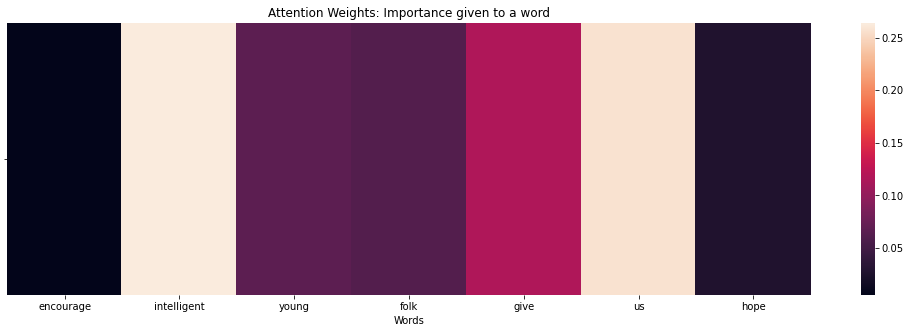

1/1 [==============================] - 0s 58ms/step


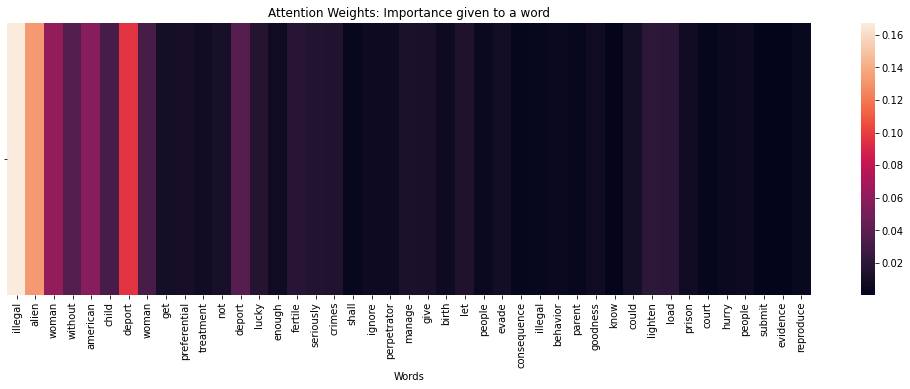

1/1 [==============================] - 0s 59ms/step


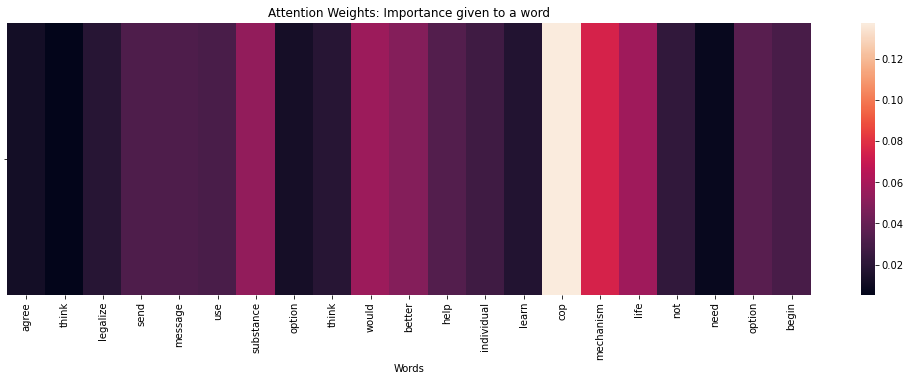

1/1 [==============================] - 0s 47ms/step


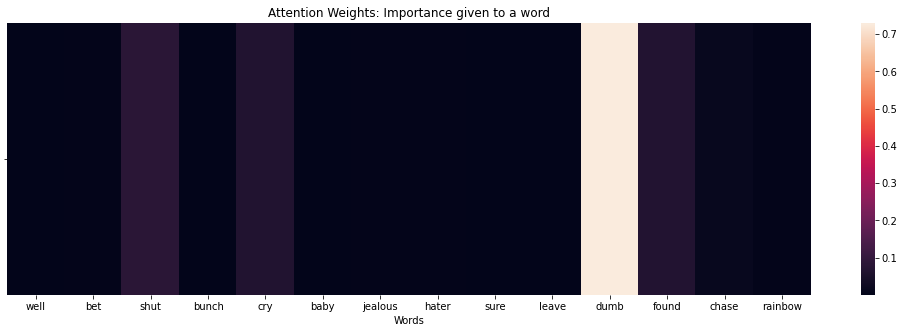

1/1 [==============================] - 0s 55ms/step


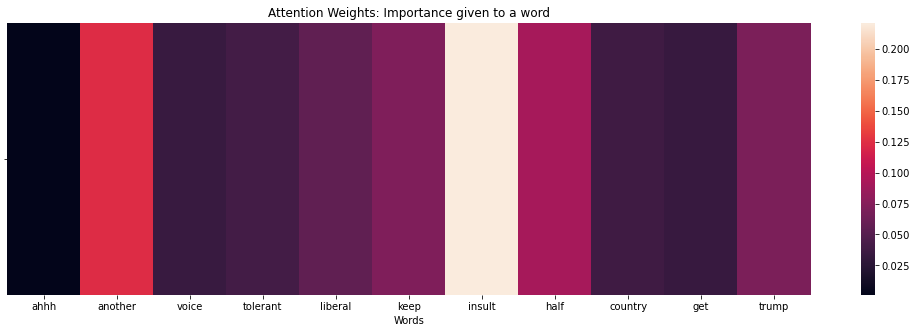

In [121]:
padlen = 105
tok_path = '/content/gdrive/MyDrive/Jigsaw Files/No Split/tokenizer.pkl'
tok =  pickle.load(open(tok_path, 'rb'))
mod_path = '/content/gdrive/MyDrive/Jigsaw Files/Models & Weights/model_4'
mod = load_model(mod_path, contain_custom_obj=True)
att = mod.get_layer('attention_with_context').output[1]
att_mod = Model(inputs=mod.input, outputs=att)

for text in sample['comment_text'].values:
    viz_attention(text, tok, padlen, att_mod)

- The above plots depict the importance given to each word in a text while classifying the text. 
